<a href="https://colab.research.google.com/github/IshanKapadia-Data/Predicting-F1-RaceWinner/blob/main/Predicting_F1_RaceWinners_Miami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

\Evaluation Metrics:
Mean Absolute Error (MAE): 0.232 seconds
R-squared Score: 0.912

🏁 Predicted Podium for 2025 Miami GP 🏁

  PredictedPosition Driver      Team  ModelPredictedPace
2                P1    PIA   McLaren           93.232111
1                P2    NOR   McLaren           93.428600
0                P3    VER  Red Bull           93.524949


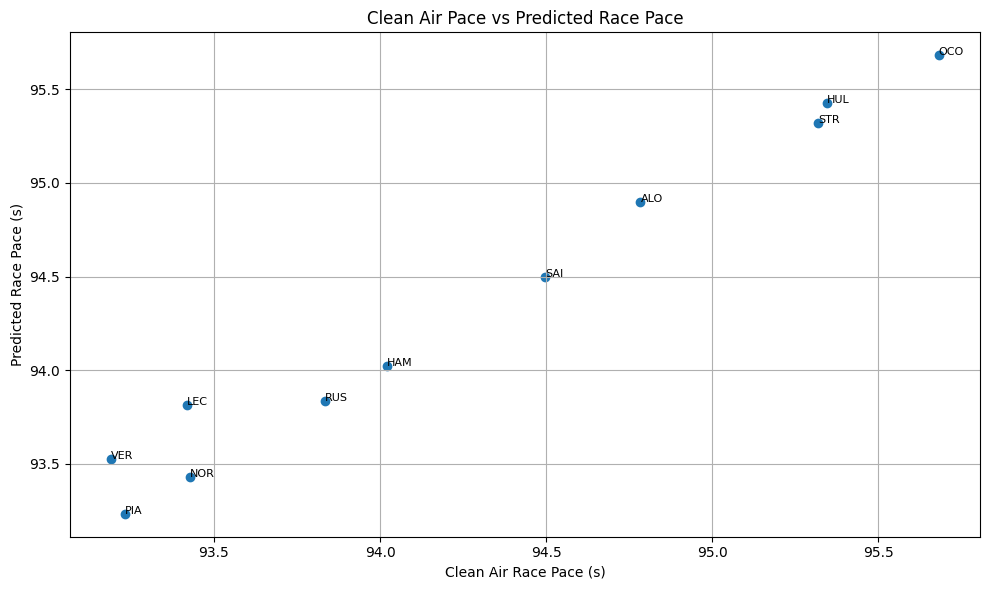

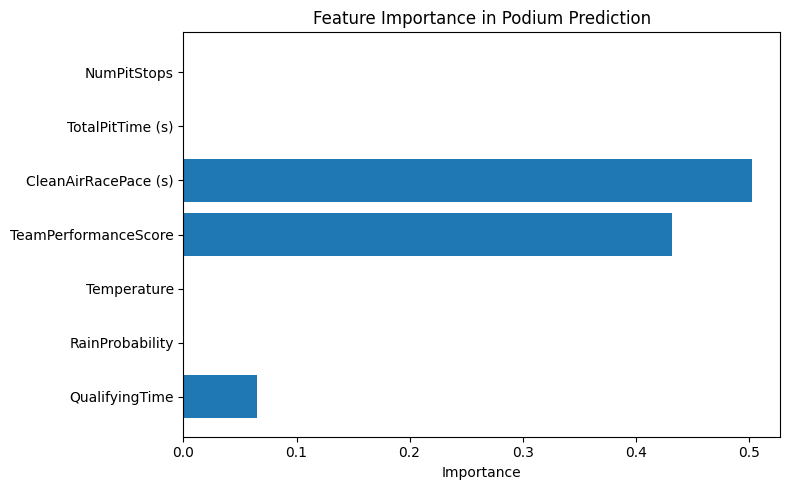

In [5]:
import os
import pandas as pd
import numpy as np
import requests
import fastf1
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import logging

# Suppress FastF1 logs
logging.getLogger('fastf1').setLevel(logging.WARNING)
logging.getLogger('urllib3').setLevel(logging.WARNING)


# ========== Configuration ==========
API_KEY = os.getenv("OPENWEATHER_API_KEY", "REPLACE_KEY")  # Replace with OPEN WEATHER API
WEATHER_LAT = 25.7617
WEATHER_LON = -80.1918
FORECAST_TIME = "2025-05-04 13:00:00"

# ========== Initialize FastF1 Cache ==========
os.makedirs("f1_cache", exist_ok=True)
fastf1.Cache.enable_cache("f1_cache")

# ========== Load Race Session Data ==========
session = fastf1.get_session(2024, "Miami", "R")
session.load()
laps = session.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time", "PitInTime", "PitOutTime", "LapNumber"]].copy()
laps.dropna(subset=["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"], inplace=True)

# ========== Convert Time Data ==========
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    laps[f"{col} (s)"] = laps[col].dt.total_seconds()

# ========== Compute Sector Times ==========
sector_times = laps.groupby("Driver").agg({
    "Sector1Time (s)": "mean",
    "Sector2Time (s)": "mean",
    "Sector3Time (s)": "mean"
}).reset_index()
sector_times["TotalSectorTime (s)"] = (
    sector_times["Sector1Time (s)"] + sector_times["Sector2Time (s)"] + sector_times["Sector3Time (s)"]
)

# ========== Pit Stop Summary ==========
pitstops = laps[laps["PitInTime"].notna() & laps["PitOutTime"].notna()].copy()
pitstops["Duration"] = (pitstops["PitOutTime"] - pitstops["PitInTime"]).dt.total_seconds()
pit_summary = pitstops.groupby("Driver").agg({
    "Duration": "sum",
    "LapNumber": "count"
}).rename(columns={"Duration": "TotalPitTime (s)", "LapNumber": "NumPitStops"}).reset_index()

# ========== External Inputs ==========
clean_air_race_pace = {
    "VER": 93.191067, "HAM": 94.020622, "LEC": 93.418667, "NOR": 93.428600, "ALO": 94.784333,
    "PIA": 93.232111, "RUS": 93.833378, "SAI": 94.497444, "STR": 95.318250, "HUL": 95.345455, "OCO": 95.682128
}

qualifying_data = pd.DataFrame({
    "Driver": ["VER", "NOR", "PIA", "RUS", "SAI", "ALB", "LEC", "OCO", "TSU", "HAM", "STR", "GAS", "ALO", "HUL"],
    "QualifyingTime (s)": [86.204, 86.269, 86.375, 86.385, 86.569, 86.682, 86.754, 86.824,
                           86.943, 87.006, 87.830, 87.710, 87.604, 87.473]
})
qualifying_data["CleanAirRacePace (s)"] = qualifying_data["Driver"].map(clean_air_race_pace)

# ========== Weather Data ==========
weather_url = f"http://api.openweathermap.org/data/2.5/forecast?lat={WEATHER_LAT}&lon={WEATHER_LON}&appid={API_KEY}&units=metric"
response = requests.get(weather_url)
weather_data = response.json()
forecast = next((f for f in weather_data.get("list", []) if f["dt_txt"] == FORECAST_TIME), None)
rain = forecast["pop"] if forecast else 0
temp = forecast["main"]["temp"] if forecast else 20

# ========== Team Performance Scores ==========
team_points = {
    "McLaren": 203, "Mercedes": 118, "Red Bull": 92, "Williams": 25, "Ferrari": 84,
    "Haas": 20, "Aston Martin": 14, "Kick Sauber": 6, "Racing Bulls": 8, "Alpine": 7
}
max_pts = max(team_points.values())
team_score = {team: pts / max_pts for team, pts in team_points.items()}

driver_team = {
    "VER": "Red Bull", "NOR": "McLaren", "PIA": "McLaren", "LEC": "Ferrari", "RUS": "Mercedes",
    "HAM": "Mercedes", "GAS": "Alpine", "ALO": "Aston Martin", "TSU": "Racing Bulls",
    "SAI": "Ferrari", "HUL": "Kick Sauber", "OCO": "Alpine", "STR": "Aston Martin"
}
qualifying_data["Team"] = qualifying_data["Driver"].map(driver_team)
qualifying_data["TeamPerformanceScore"] = qualifying_data["Team"].map(team_score)
qualifying_data["QualifyingTime"] = qualifying_data["QualifyingTime (s)"] ** 2

# ========== Merge & Feature Set ==========
df = qualifying_data.merge(sector_times[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
df = df.merge(pit_summary, on="Driver", how="left")
df["RainProbability"] = rain
df["Temperature"] = temp
df["LastYearWinner"] = (df["Driver"] == "VER").astype(int)
df["TotalPitTime (s)"] = df["TotalPitTime (s)"].fillna(0)
df["NumPitStops"] = df["NumPitStops"].fillna(0)

X = df[[
    "QualifyingTime", "RainProbability", "Temperature", "TeamPerformanceScore",
    "CleanAirRacePace (s)", "TotalPitTime (s)", "NumPitStops"
]]
y = df["CleanAirRacePace (s)"] + 0.5 * df["TotalPitTime (s)"] / 50

# ========== Handle Missing Target ==========
mask = y.notna()
X, y, df = X[mask], y[mask], df[mask]

# ========== Modeling ==========
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=47)

model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=47)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# ========== Evaluation ==========
print("\Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred):.3f} seconds")
print(f"R-squared Score: {r2_score(y_test, y_pred):.3f}")

# ========== Predictions ==========
df["ModelPredictedPace"] = model.predict(X_imputed)
df = df.sort_values("ModelPredictedPace")
df["PredictedPosition"] = "Other"
if len(df) >= 3:
    df.iloc[0, df.columns.get_loc("PredictedPosition")] = "P1"
    df.iloc[1, df.columns.get_loc("PredictedPosition")] = "P2"
    df.iloc[2, df.columns.get_loc("PredictedPosition")] = "P3"

# ========== Podium Output ==========
podium = df[df["PredictedPosition"].isin(["P1", "P2", "P3"])]
print("\n🏁 Predicted Podium for 2025 Miami GP 🏁\n")
print(podium[["PredictedPosition", "Driver", "Team", "ModelPredictedPace"]])

# ========== Visualization ==========
plt.figure(figsize=(10, 6))
plt.scatter(df["CleanAirRacePace (s)"], df["ModelPredictedPace"])
for i, row in df.iterrows():
    plt.annotate(row["Driver"], (row["CleanAirRacePace (s)"], row["ModelPredictedPace"]), fontsize=8)
plt.xlabel("Clean Air Race Pace (s)")
plt.ylabel("Predicted Race Pace (s)")
plt.title("Clean Air Pace vs Predicted Race Pace")
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Feature Importance ==========
importances = model.feature_importances_
features = X.columns
plt.figure(figsize=(8, 5))
plt.barh(features, importances)
plt.xlabel("Importance")
plt.title("Feature Importance in Podium Prediction")
plt.tight_layout()
plt.show()